### Matplotlib second introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

We read: https://matplotlib.org/stable/tutorials/intermediate/artists.html
It explains basic "who is who" in matplotlib

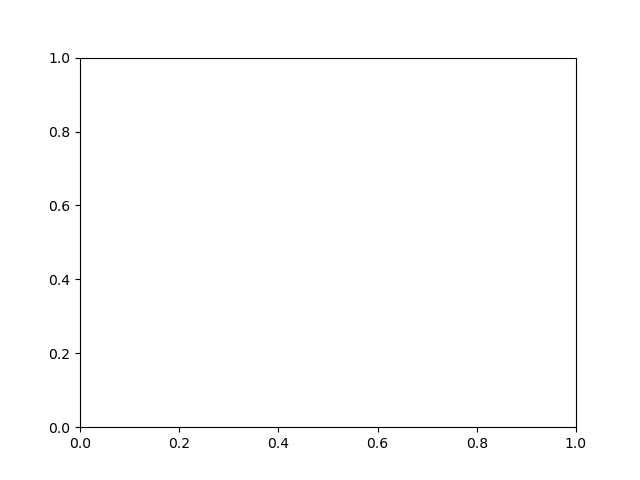

In [3]:
# %matplotlib widget

fig, ax = plt.subplots()
plt.show()

(-1.0, 1.5)

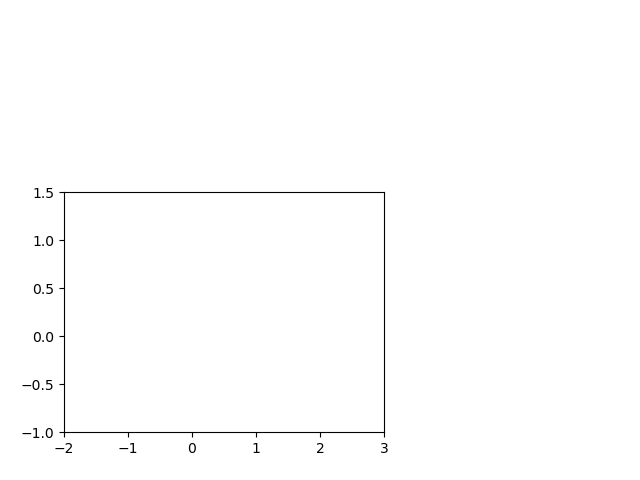

In [4]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0.1, 0.1, 0.5, 0.5])

# set the (inner) limits.
ax2.set_xlim([-2, 3])
ax2.set_ylim([-1, 1.5])



(-1.0, 1.5)

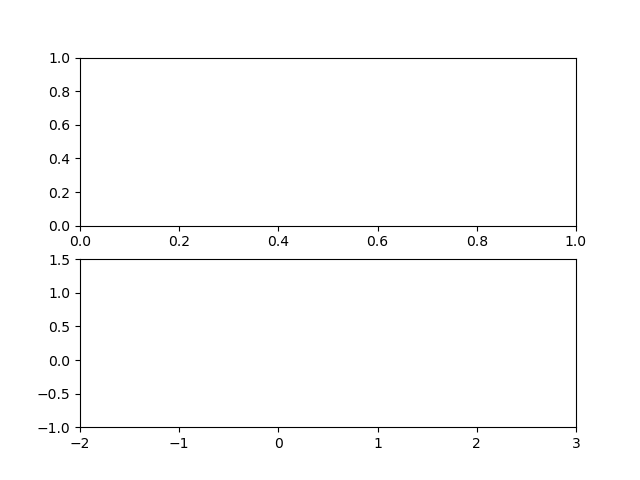

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_subplot(2, 1, 1)

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlim([-2, 3])
ax2.set_ylim([-1, 1.5])

# ax3 = fig.add_subplot(3, 4, 7) # you can add more suplots over existing subplots

### Birds with time on a slider.

In [2]:
""" Creating birds data."""
import numpy as np
from numpy.random import default_rng, SeedSequence

### initial condition functions ###
def set_random_y0(N, seed, low=0, high=1, velo_st_dev=4):
    """Produces an initial CS_matrix"""
    rng = default_rng(SeedSequence(seed))
    
    x_s = rng.uniform(low=low, high=high, size=N) # x coordinates of intial position
    y_s = rng.uniform(low=low, high=high, size=N) # y coordinates of intial position

    vx_s = velo_st_dev*rng.standard_normal(N) # x coordinates of intial velocity
    vy_s = velo_st_dev*rng.standard_normal(N) # y coordinates of intial velocity

    y_0 = np.c_[x_s, y_s, vx_s, vy_s] #returns a CS_matrix - initial condition
    return y_0

n = 50
def comm_weight(s):
    """Communication weight in Cucker-Smale model"""
    return 0.5*np.float_power(s, -0.01, out=np.zeros_like(s), where=s!=0)

from typing import Callable

def rhs_func(t: float, y: np.ndarray, mass: np.ndarray, comm_weight: Callable)-> np.ndarray:
    """ The splitting of dx and dv is done here. 
            t           : independent variable in the ODE
            y           : CS_data_point of the shape (N*4,)
            mass        : array of "masses" we can set that some birds are more important than other
            comm_weight : callable 'communication weight' funtion
        """
    def rhs_d_pos(y):
        u = y.copy()
        u[:,0], u[:,1] = 0, 0    # zeroing the position
        return u[:,[2,3,0,1]]    # velocities go to the front

    def rhs_d_vel(y, mass=0, comm_weight=0):
        """ docs """
        #split position and velocity
        N = len(y)
        vel = y.copy()
        vel[:,0], vel[:,1] = 0, 0
        pos = y.copy()
        pos[:,2], pos[:,3] = 0, 0

        # stack of matricies of all diferences of velocities
        vel_diff = np.stack([vel]*N,axis=0) - np.stack([vel]*N,axis=1)

        # stack of matricies of all diferences of position
        pos_diffs = np.stack([pos]*N,axis=0) - np.stack([pos]*N,axis=1)

        # the values of eta function on distances 
        vcomm_weight = np.vectorize(comm_weight)
        weighted_diffs = vcomm_weight(np.linalg.norm(pos_diffs, axis=2, keepdims=True))

        return np.sum( weighted_diffs*vel_diff, axis=1 )

    # N = len(y)
    y = y.reshape(-1,4)    # this is for technical reasons = solve_ivp was not working for me with the .shape =(N, 4) so i'm using .shape=(N*4,)
    x_derivatives = rhs_d_pos(y)
    y_derivatives = rhs_d_vel(y, mass, comm_weight)
    rhs = x_derivatives + y_derivatives
    return rhs.ravel()

y0 = set_random_y0(n,12346)

from scipy.integrate import solve_ivp
birds = solve_ivp(lambda t, y: rhs_func(t , y, 0, comm_weight),
        (0, 0.2),
        y0.ravel(),
        method='RK45',
        # t_eval = np.linspace(self.t0, self.t0+self.duration, int(self.duration*self.fps/self.speed)),
        dense_output=True
        )
birds.message

'The solver successfully reached the end of the integration interval.'

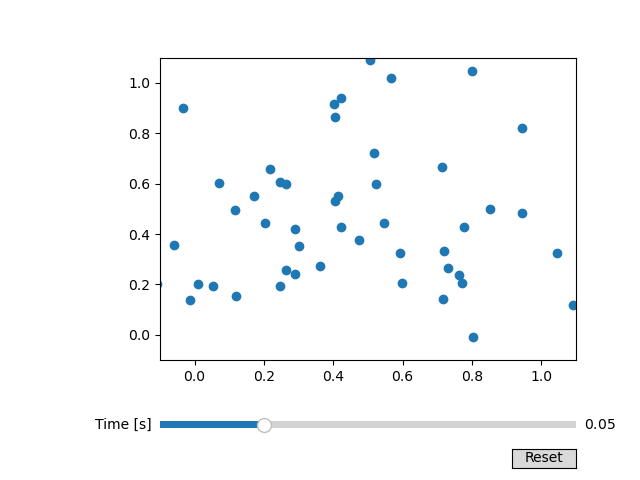

In [3]:
""" drawing birds example """
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# Define initial parameter
init_time = 0.05

# Create the figure and the points that we will manipulate
fig, ax = plt.subplots()
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
bird_points = plt.scatter(*(birds.sol(init_time).reshape(-1,4)[:,:2].T))

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the time.
axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax = axtime,
    label='Time [s]',
    valmin=0,
    valmax=0.2,
    valinit=init_time,
)

# The function to be called anytime a slider's value changes
def update(val):
    bird_points.set_offsets(birds.sol(time_slider.val).reshape(-1,4)[:,:2])
    fig.canvas.draw_idle()

# register the update function with each slider    
time_slider.on_changed(update)

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    time_slider.reset()
button.on_clicked(reset)

plt.show()

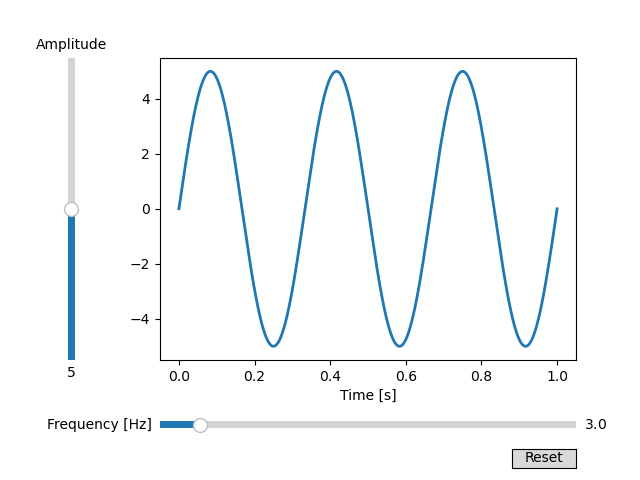

In [4]:
""" matplotlib sliders example from https://matplotlib.org/stable/gallery/widgets/slider_demo.html """
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

### Animation

In [ ]:
""" Again start with an example from docs from the page:
        https://matplotlib.org/stable/api/animation_api.html 
    there an example- animated line plot:
        https://matplotlib.org/stable/gallery/animation/simple_anim.html
    """
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x)*0.1)


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

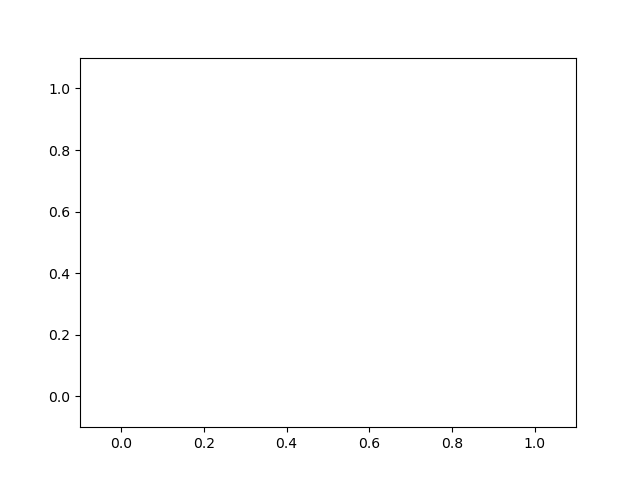

In [8]:
""" Change the example to fit our problem """
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and the points that we will animate
fig, ax = plt.subplots()
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])

# birds_anim = plt.scatter(*(birds.sol(0).reshape(-1,4)[:,:2].T))
birds_anim = plt.scatter([],[])

def animate(i):
    birds_anim.set_offsets(birds.sol(i).reshape(-1,4)[:,:2])  # update the data.
    return birds_anim,

# frames of the future animation
ani_frames = np.linspace(0,0.2,200)

ani = animation.FuncAnimation(
    fig, animate, interval=40, blit=False, frames = ani_frames, repeat = False)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

### Simulation 
Example below is heavly inspiread by: https://youtu.be/Ercd-Ip5PfQ


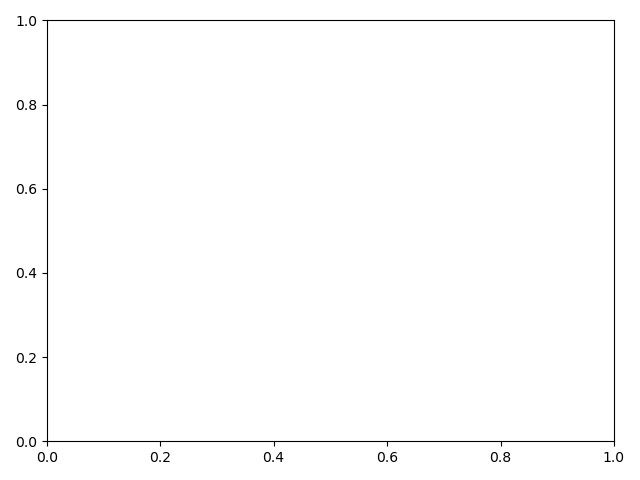

In [5]:
%matplotlib widget

import numpy as np
from numpy.random import default_rng, SeedSequence

from itertools import count
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
plt.style.use('bmh')#('fivethirtyeight')


seed1=12345
rng1 = default_rng(SeedSequence(seed1))
seed2=123456
rng2 = default_rng(SeedSequence(seed2))


index = count()
x_vals = [-1]
y_vals1 = [0]
y_vals2 = [0]

def animate(i):
    x_vals.append(next(index))
    
    y_vals1.append(y_vals1[-1]+rng1.normal(loc=0.0, scale=1.0))
    y_vals2.append(y_vals2[-1]+rng2.normal(loc=0.0, scale=1.0))
    ax.cla()
    ax.plot(x_vals, y_vals1, c='tab:blue')
    ax.plot(x_vals, y_vals2, c='tab:orange')
    return ax,

ani = FuncAnimation(plt.gcf(), animate, interval=500)

plt.tight_layout()
plt.show()

#### Reproduction of random generator
Let's say that we want to create a reproducible plot of the kind above but with arbitrary number of random walks.
SeedSequence comes to our aid.

In [2]:
import numpy as np
from numpy.random import default_rng, SeedSequence

ss = SeedSequence(12345)
child_seeds = ss.spawn(2)
rngs = [default_rng(s) for s in child_seeds]

In [3]:
""" check what child seeds are """
child_seeds

[SeedSequence(
     entropy=12345,
     spawn_key=(0,),
 ),
 SeedSequence(
     entropy=12345,
     spawn_key=(1,),
 )]

In [4]:
""" now you can reproduce the randomly generated numbers in some organised manner """
ss = SeedSequence(12345)
child_seeds = ss.spawn(2)
rngs = [default_rng(s) for s in child_seeds]
print(child_seeds[0])
rngs[0].normal(loc=0.0, scale=1.0, size=5)

SeedSequence(
    entropy=12345,
    spawn_key=(0,),
)


array([ 1.78751978, -0.4886409 ,  1.08237292, -0.449911  , -0.54109887])

In [5]:
""" is the same as """
ss_custom = SeedSequence(12345, spawn_key=(0,))
default_rng(ss_custom).normal(loc=0.0, scale=1.0, size=5)

array([ 1.78751978, -0.4886409 ,  1.08237292, -0.449911  , -0.54109887])

In [6]:
""" because default_rng is determined by SeedSequence """
print(SeedSequence(12345, spawn_key=(0,),) ,'\n', child_seeds[0])

# """ every element of seed sequence can spawn more seed sequences with the same spawn procedure like this:"""
# grand_childs = child_seeds[1].spawn(3)

# """ Their spawn_key is has now two elements indicating they are childs of (1,) """
# print(grand_childs)

# """ Original SeedSequence are also updated."""
# print(ss,child_seeds)

SeedSequence(
    entropy=12345,
    spawn_key=(0,),
) 
 SeedSequence(
    entropy=12345,
    spawn_key=(0,),
)


#### Let's update our simulation of random walk

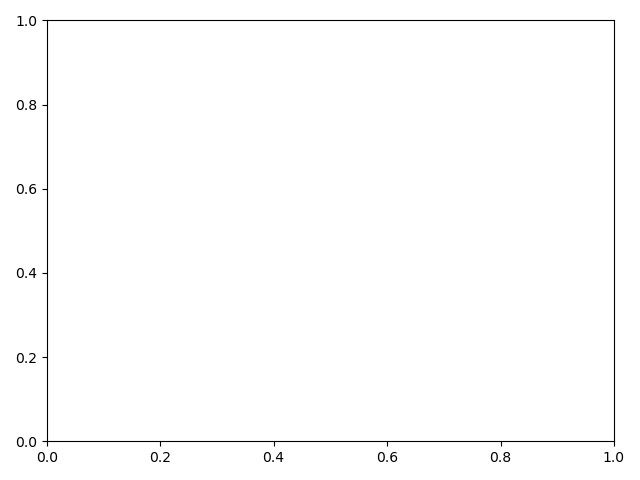

In [1]:
%matplotlib widget

import numpy as np
from numpy.random import default_rng, SeedSequence

from itertools import count
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
plt.style.use('bmh')#('fivethirtyeight')

seed = 12345
num_of_walks = 3

ss = SeedSequence(seed)
child_seeds = ss.spawn(num_of_walks)
rngs = [default_rng(s) for s in child_seeds]

index = count()
x_vals = [-1]
y_vals = [ [0] for _ in range(num_of_walks)]

def animate(i):
    x_vals.append(next(index))
    # below we cannot iterate over y_vals, since we change y_vals during the process
    for i in range(num_of_walks): 
        y_vals[i].append(y_vals[i][-1] + rngs[i].normal(loc=0.0, scale=1.0))
    ax.cla()
    ax.plot(x_vals, y_vals[0], c='tab:blue')
    ax.plot(x_vals, y_vals[1], c='tab:orange')
    ax.plot(x_vals, y_vals[2], c='tab:green')
    return ax,

ani = FuncAnimation(plt.gcf(), animate, interval=100)

plt.tight_layout()
plt.show()

In [3]:
""" The difference list comrechension vs. [[0]]*n example with append"""
num_of_walks = 3
y_vals = [ [0] for _ in range(num_of_walks)]
y_vals_copy = y_vals.copy()

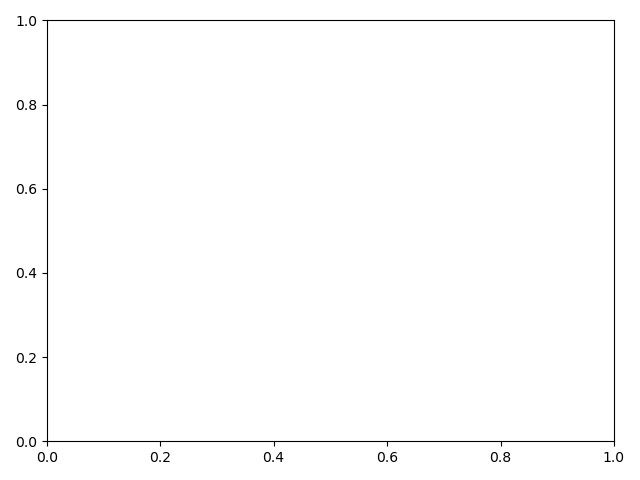

In [4]:
%matplotlib widget

import numpy as np
from numpy.random import default_rng, SeedSequence

from itertools import count
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
plt.style.use('bmh')#('fivethirtyeight')

seed = 12345
num_of_walks = 5

ss = SeedSequence(seed)
child_seeds = ss.spawn(num_of_walks)
rngs = [default_rng(s) for s in child_seeds]

index = count()
x_vals = [-1]
y_vals = [ [0] for _ in range(num_of_walks)]

def animate(i):
    x_vals.append(next(index))
    # below we cannot iterate over y_vals, since we change y_vals during the process
    for i in range(num_of_walks): 
        y_vals[i].append(y_vals[i][-1] + rngs[i].normal(loc=0.0, scale=1.0))
    ax.cla()
    for i in range(num_of_walks): 
        ax.plot(x_vals, y_vals[i])
    return ax,

ani = FuncAnimation(plt.gcf(), animate, interval=5)

plt.tight_layout()
plt.show()

How to control colors of series of plots. In the example above they are drawn in the same order thats why it works. but if we wanted to control color we need to:

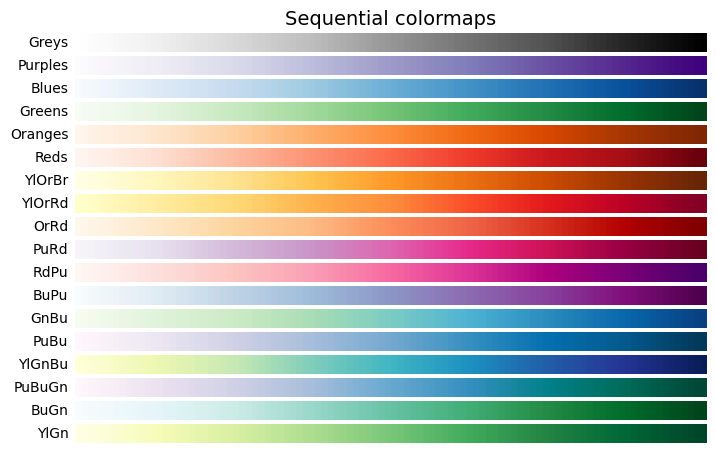

In [1]:
""" Example: https://matplotlib.org/stable/tutorials/colors/colormaps.html"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


cmaps = {}

gradient = np.linspace(0, 1, 100)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(8,figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

plot_color_gradients('Sequential',
                     ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])

Let's use colormap to color arbitrary number of random walks.
1. Every walk has one color.
2. Color depends on the value (like a height map)

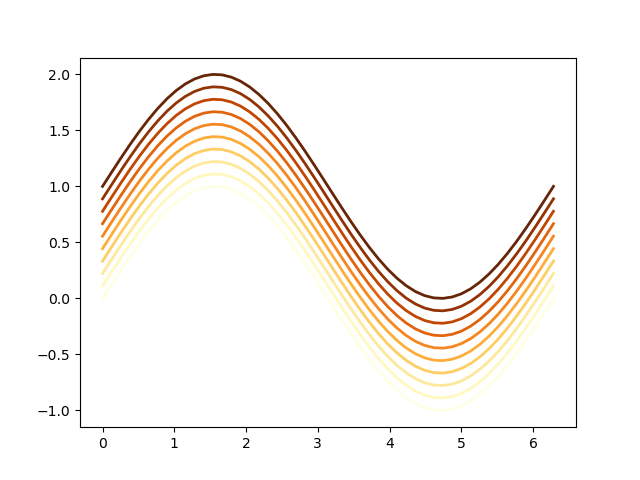

In [2]:
%matplotlib widget

import numpy as np
# from numpy.random import default_rng, SeedSequence

# from itertools import count
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
plt.style.use('bmh')

num = 10 #check 50
pts = np.linspace(0, 2*np.pi, 50)
col = np.linspace(0,1,num)

for i,c in enumerate(col):
    ax.plot(pts,np.sin(pts)+c, color=mpl.colormaps['YlOrBr'](c))


Plot colors a line so to draw a line/curve with many colors we have to use differet method of drawing.\
Let's see the example form: https://matplotlib.org/stable/gallery/color/color_by_yvalue.html

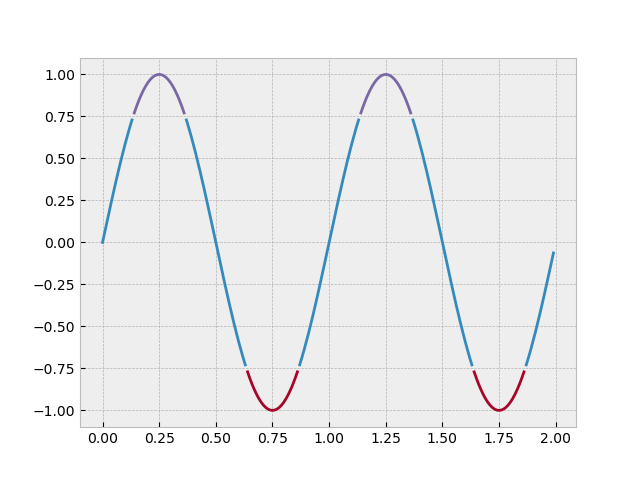

In [56]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(0.0, 2.0, 0.01)
s = np.sin(2 * np.pi * t)

upper = 0.77
lower = -0.77

supper = np.ma.masked_where(s < upper, s)
slower = np.ma.masked_where(s > lower, s)
smiddle = np.ma.masked_where((s < lower) | (s > upper), s)
#discuss masked_where

fig, ax = plt.subplots()
ax.plot(t, smiddle, t, slower, t, supper)
plt.show()

# """ Notice the syntax of ax.plot allow for :""" 
# fig, ax = plt.subplots()
# ax.plot(t, smiddle,'--', t, slower,'r', t, supper,'g-.')
# plt.show()

To obtain smooth color of plot we may use scatter: 

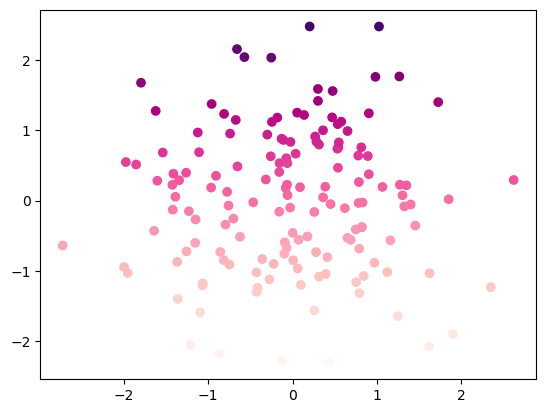

In [2]:
import numpy as np
from numpy.random import default_rng, SeedSequence

import matplotlib.pyplot as plt


n, seed = 150, 12345
rng = default_rng(SeedSequence(seed))

x = rng.standard_normal(n)
y = rng.standard_normal(n)

fig, ax = plt.subplots()

ax.scatter(x, y, c=y, cmap='RdPu') # discuss parameters c= and cmap=
plt.show()

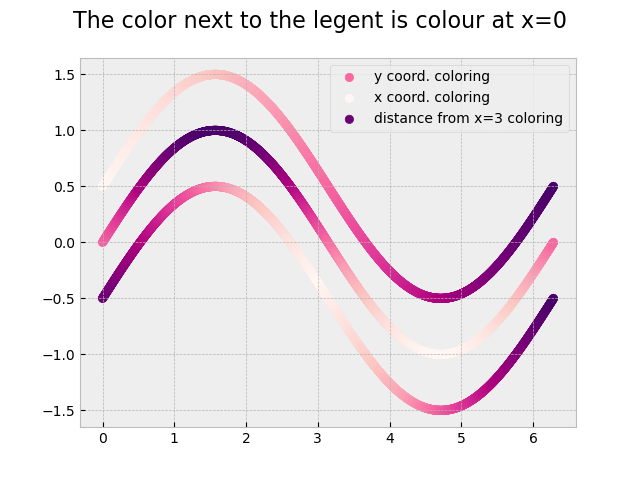

In [15]:
import numpy as np
from numpy.random import default_rng, SeedSequence


n, seed = 150, 12345
rng = default_rng(SeedSequence(seed))

pts = np.linspace(0, 2*np.pi, 2000)
val = np.sin(pts)

fig, ax = plt.subplots()
fig.suptitle('The color next to the legent is colour at x=0', fontsize=16)

ax.scatter(pts, val, c=val, cmap='RdPu',
           label='y coord. coloring')
ax.scatter(pts, val+0.5, c=pts, cmap='RdPu',
           label='x coord. coloring')
ax.scatter(pts, val-0.5, c=np.abs(pts-3), cmap='RdPu',
           label='distance from x=3 coloring' )

ax.legend()
plt.show()

#### Arguments, stars, commas, value assiments  
In argument of a function: https://youtu.be/R8-oAqCgHag 
In assigning: https://stackoverflow.com/questions/6967632/unpacking-extended-unpacking-and-nested-extended-unpacking

Note that we have \
```return ax,```

In [35]:
var,

((1, 2),)

### k - closest, torus topology of birds